In [17]:
from icecream import ic
import numpy as np

# Caption generation model:

We'll create a model that takes the gpt2 and resnet18 and joints them together. 
The idea is that for each image passed, some features will be computed and then fed to the network as the output layer of its embedding layer.

Load GPT2:

In [18]:
from transformers import GPT2Tokenizer, GPT2LMHeadModel
tokenizer = GPT2Tokenizer.from_pretrained('gpt2')
gpt2 = GPT2LMHeadModel.from_pretrained('gpt2')

Load ResNet18

In [19]:
import torchvision.models as models
import torchvision.transforms as transforms
from PIL import Image
resnet18 = models.resnet18(pretrained=True)

/Users/josepsmachine/miniforge3/envs/ML/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/josepsmachine/miniforge3/envs/ML/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [20]:
import torch
import torch.nn as nn

In [21]:
RESNET18_EMB_DIM = 1000
GPT2_HIDDEN_DIM = 768

This is what the gpt2 embedding outputs, note the extra batch dimension.

In [22]:
gpt2.transformer.wte.forward(torch.tensor([[0,1,4]])).shape

torch.Size([1, 3, 768])

In [23]:
class hacky_embedding(torch.nn.Module):
    def __init__(self,gpt2,batch_size):
        super(hacky_embedding, self).__init__()
        self.gpt2_emb = gpt2.transformer.wte
        self.image_embeddings = torch.tensor([]) #img embeddings will be indexed by "idx of token in sequence":torch.tensor(embedding) 
    
    def forward(self,sequence):
        #embedd passed sequence
        embb = self.gpt2_emb.forward(sequence)
        for batch in range(self.image_embeddings.shape[0]): 
            embb[batch,0:self.image_embeddings.shape[1]] = nn.Parameter(self.image_embeddings[0],requires_grad=False)
        
        return embb

In [24]:
gpt2(torch.tensor([0,0,1,1]))

CausalLMOutputWithCrossAttentions(loss=None, logits=tensor([[-37.7548, -38.2650, -40.4858,  ..., -47.3886, -46.8040, -36.8604],
        [-81.0518, -84.1306, -83.3997,  ..., -94.5055, -92.6123, -80.7604],
        [-65.1760, -65.8758, -65.1255,  ..., -71.7693, -70.8514, -60.8464],
        [-67.8912, -68.1553, -67.2185,  ..., -75.4527, -74.3929, -64.4624]],
       grad_fn=<MmBackward0>), past_key_values=((tensor([[[[-1.2244,  2.2710,  0.7146,  ..., -1.3720, -0.7829,  1.6593],
          [-1.9040,  2.7886,  1.6871,  ..., -1.4662, -1.6265,  2.1685],
          [-1.8813,  2.4597,  2.3586,  ..., -1.2989, -1.5504,  2.1998],
          [-1.9049,  2.4547,  2.5031,  ..., -1.2256, -1.6144,  2.2291]],

         [[ 0.2663,  0.0910, -0.5775,  ..., -0.6575,  0.7794,  0.6989],
          [ 0.0414, -0.8678, -1.5299,  ..., -1.5589,  2.0947,  1.0774],
          [-1.1064, -0.5916, -1.4426,  ..., -0.7746,  4.9179,  0.8812],
          [-1.1050, -0.5506, -1.4022,  ..., -0.7737,  4.9662,  0.9430]],

         [[ 0.

In [25]:
gpt2.transformer

GPT2Model(
  (wte): Embedding(50257, 768)
  (wpe): Embedding(1024, 768)
  (drop): Dropout(p=0.1, inplace=False)
  (h): ModuleList(
    (0-11): 12 x GPT2Block(
      (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (attn): GPT2Attention(
        (c_attn): Conv1D()
        (c_proj): Conv1D()
        (attn_dropout): Dropout(p=0.1, inplace=False)
        (resid_dropout): Dropout(p=0.1, inplace=False)
      )
      (ln_2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (mlp): GPT2MLP(
        (c_fc): Conv1D()
        (c_proj): Conv1D()
        (act): NewGELUActivation()
        (dropout): Dropout(p=0.1, inplace=False)
      )
    )
  )
  (ln_f): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
)

In [26]:
class caption_generator(torch.nn.Module):
    def __init__(self,gpt2,resnet18,tokens_per_img,batch_size):
        super(caption_generator, self).__init__()
        self.gpt2 = gpt2
        self.config = self.gpt2.config
        self.hacky_embedding = hacky_embedding(gpt2,batch_size).train()
        self.gpt2.transformer.wte = self.hacky_embedding #replace embedding layer with our own

        self.resnet18 = resnet18

        self.TOKENS_PER_IMG = tokens_per_img

        #layers that convert the img features into embedding 
        self.imgfeat_to_gpt2emb = nn.Sequential(
            nn.Linear(RESNET18_EMB_DIM,3000),
            nn.ReLU(),
            nn.Linear(3000,1000*tokens_per_img),
            nn.ReLU(),
            nn.Linear(1000*tokens_per_img,1000*tokens_per_img),
            nn.ReLU(),
            nn.Linear(1000*tokens_per_img,tokens_per_img*GPT2_HIDDEN_DIM),
            nn.ReLU(), #should I have this layer here? What is the range of values in gpt2 emb layer?
        )
    
    def forward(self,img,train=True,caption=None):
        """
        Forward function of the caption_generator model class.

        Input: img (torch.tensor)
            params: train, caption
                if train=True a caption is expected and will train the model to predict that
                if train=False no caption is expected and the model will generate a new one.
                Note: caption should already come tokenized
        Output: 
                if train=True gpt2 losses for each token and generated caption(tokenized)
                if train=False generated caption(tokenized)

        """
        #extract features with resnet:
        features = resnet18(img)

        #generate gpt2_embeddings
        concat_embs = self.imgfeat_to_gpt2emb(features)
        
        img_emb = concat_embs[:,0:(1)*GPT2_HIDDEN_DIM].unsqueeze(1) #axis0 is batch
        for i in range(1,self.TOKENS_PER_IMG):
            extracted_emb = concat_embs[:,i*GPT2_HIDDEN_DIM:(i+1)*GPT2_HIDDEN_DIM]
            extracted_emb  = extracted_emb.unsqueeze(1) #create sequence dimension
            img_emb = torch.cat((img_emb,extracted_emb),axis=1) #axis0 is batch
        
        
        #same image embeddings to the hacky embedding layer
        self.hacky_embedding.image_embeddings = img_emb
        ic(img_emb.shape)
        #generate a random sequence of tokens for each emb in image emb
        tokens = torch.zeros((img_emb.shape[0],img_emb.shape[1]),dtype=int).to(device)
        ic(tokens.shape)
        ##CAPTION TRAINING
        if train: #at training we feed a caption
            assert caption is not None, "No caption passed! ᑫ⇀ᨓ↼ᑷ"
            ic(caption.shape)
            #add caption tokens to the already embedded image sequence
            tokens = torch.cat((tokens,caption),axis=1)
            ic(tokens.shape)

        input = {}
        input["input_ids"] = tokens
        input["attention_mask"] = torch.ones((tokens.shape[0],tokens.shape[1]),dtype=int).to(device)

        output = self.gpt2.forward(**input)
        logits = output["logits"]
        caption_logits = logits[:,img_emb.shape[1]:,:]
        #return only hidden states for tokens (in seq lenght ) representing the caption
        return caption_logits


In [27]:
device = "mps"

In [28]:
model = caption_generator(gpt2,resnet18,tokens_per_img=5,batch_size=2)
model.to(device)

caption_generator(
  (gpt2): GPT2LMHeadModel(
    (transformer): GPT2Model(
      (wte): hacky_embedding(
        (gpt2_emb): Embedding(50257, 768)
      )
      (wpe): Embedding(1024, 768)
      (drop): Dropout(p=0.1, inplace=False)
      (h): ModuleList(
        (0-11): 12 x GPT2Block(
          (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
          (attn): GPT2Attention(
            (c_attn): Conv1D()
            (c_proj): Conv1D()
            (attn_dropout): Dropout(p=0.1, inplace=False)
            (resid_dropout): Dropout(p=0.1, inplace=False)
          )
          (ln_2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
          (mlp): GPT2MLP(
            (c_fc): Conv1D()
            (c_proj): Conv1D()
            (act): NewGELUActivation()
            (dropout): Dropout(p=0.1, inplace=False)
          )
        )
      )
      (ln_f): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
    )
    (lm_head): Linear(in_features=768, out_features=50257, bi

Get a test image:

In [29]:
mean = torch.tensor([0.45802852,0.44609796,0.40391668])
std=torch.tensor([0.24219123,0.23320058,0.23719894])

In [30]:
preprocess = transforms.Compose([
    transforms.Resize((224, 224)), # Resize the image: ResNet model  - > (224,224,3)
    transforms.ToTensor(), # Img to Python Tensor
    transforms.Normalize(mean=mean, std=std), # image = (image - mean) / std
])

In [31]:
import matplotlib.pyplot as plt

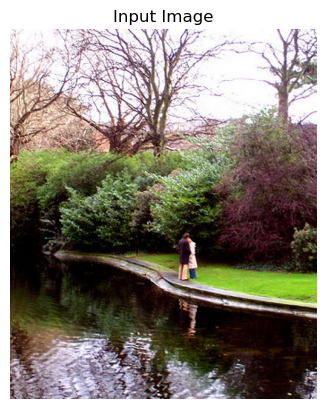

In [33]:
input_image = Image.open("dataset/Images/3637013_c675de7705.jpg").convert('RGB')

plt.imshow(input_image)
plt.axis('off')
plt.title("Input Image")

input_image = preprocess(input_image)
input_image = input_image.unsqueeze(0)

In [34]:
input_image.shape

torch.Size([1, 3, 224, 224])

In [35]:
batch_of_two_images = torch.cat((input_image,input_image),axis=0)
batch_of_two_images.shape

torch.Size([2, 3, 224, 224])

In [36]:
caption = ["Two persons kissing near a lake","Two persons kissing in a forest"]
tokens = tokenizer(caption,return_tensors="pt")["input_ids"]
tokens

tensor([[ 7571,  6506, 25847,  1474,   257, 13546],
        [ 7571,  6506, 25847,   287,   257,  8222]])

In [37]:
caption_logits = model.forward(batch_of_two_images.to(device),caption=tokens.to(device),train=True)

ic| img_emb.shape: torch.Size([2, 5, 768])
ic| tokens.shape: torch.Size([2, 5])
ic| caption.shape: torch.Size([2, 6])
ic| tokens.shape: torch.Size([2, 11])


In [38]:
import torch.nn.functional as F
entropy_loss = nn.CrossEntropyLoss()

In [43]:
caption_logits[0].shape

torch.Size([6, 50257])

: 

In [42]:
loss_fct = entropy_loss(F.softmax(caption_logits[0],dim=-1),tokens[0].to(device)) 

In [ ]:
loss_fct.backward() #workedd!!!!! okey we should try doing a train loop